<a href="https://colab.research.google.com/github/RafaelColin/EDP/blob/main/Ecuaci%C3%B3n_del_Calor_M%C3%A9todo_impl%C3%ADcito_de_Crank_Nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color = reen>Método implícito de Crank-Nicolson


Use los tamaños de paso  $ h =0.1$ y $ k=0.01$ para aproximar la solucion de la ecuacion de calor

$$\frac{\partial U}{\partial t}(x,t) = \frac{\partial^2 U}{\partial x^2}(x,t), 0<x<1 $$

con condiciones de frontera:

$$u(0,t) = u(1,t) = 0 , t≥0, $$

##y condiciones iniciales:

$$u(x,0) = 1-4( x-1/2 )^2, 0≤x≤1 $$
La ecuación en diferencias para el método implícito estándar es:

$$\frac{u_{i,j+1} - u_{i,j}}{k} = \frac{1}{2}[\frac{u_{i+1,j+1} - 2u_{i,j+1} + u_{i-1,j+1}}{h^2} + [\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2}]$$
Reorganizando, se obtiene:

$$-ru_{i-1,j+1} +(2 + 2r) u_{i,j+1} - r u_{i+1,j+1} = ru_{i-1,j}+(2-2r)u_{i,j} + r u_{i+1,j}$$

donde $$r= \alpha^2 \frac{k}{h^2}$$ y lo que es conocido $$ru_{i-1,j}+(2-2r)u_{i,j} + r u_{i+1,j}$$

#Librerias

In [66]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tabulate import tabulate

#Definición de la función inicial

In [67]:
def f(x):
    return 1 - 4*((x - 1/2)**2)

# Verificar la función inicial

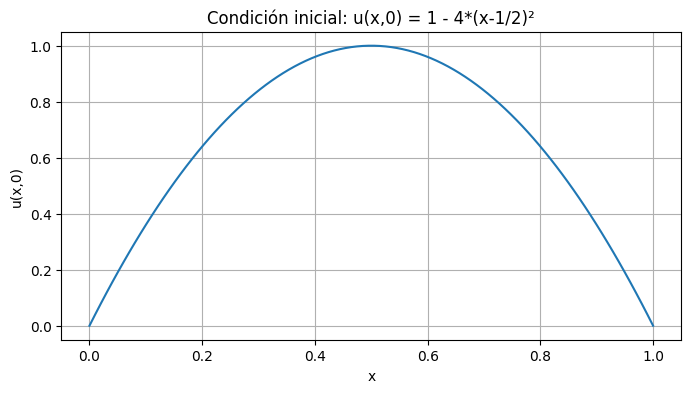

In [68]:
x_vals = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 4))
plt.plot(x_vals, f(x_vals))
plt.title('Condición inicial: u(x,0) = 1 - 4*(x-1/2)²')
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.grid(True)
plt.show()

#Parámetros

In [69]:
h = 0.1
k = 0.01
alpha = 1.0
r = alpha**2 * k / h**2
n = 9  # puntos interiores (x=0.1, 0.2, ..., 0.9)

print(f"Parámetros:")
print(f"h = {h}, k = {k}, alpha = {alpha}")
print(f"r = alpha² * k / h² = {r}")

Parámetros:
h = 0.1, k = 0.01, alpha = 1.0
r = alpha² * k / h² = 0.9999999999999998


#Construcción de las Matrizes A y B para el método de Crank-Nicolson"

In [70]:
def tridiagonal(n, a, b):
  return sp.Matrix([
      [a if i == j else b if abs(i-j) == 1 else 0 for j in range(n)]
      for i in range(n)
  ])
  r = 1

#Matris A


In [71]:
A = tridiagonal(9,2+2*r,-r)
print("Matriz A:")
A

Matriz A:


Matrix([
[ 4.0, -1.0,    0,    0,    0,    0,    0,    0,    0],
[-1.0,  4.0, -1.0,    0,    0,    0,    0,    0,    0],
[   0, -1.0,  4.0, -1.0,    0,    0,    0,    0,    0],
[   0,    0, -1.0,  4.0, -1.0,    0,    0,    0,    0],
[   0,    0,    0, -1.0,  4.0, -1.0,    0,    0,    0],
[   0,    0,    0,    0, -1.0,  4.0, -1.0,    0,    0],
[   0,    0,    0,    0,    0, -1.0,  4.0, -1.0,    0],
[   0,    0,    0,    0,    0,    0, -1.0,  4.0, -1.0],
[   0,    0,    0,    0,    0,    0,    0, -1.0,  4.0]])

#Matris B

In [72]:
B = tridiagonal(9,2-2*r,r)
print("Matriz B:")
B

Matriz B:


Matrix([
[4.44089209850063e-16,                  1.0,                    0,                    0,                    0,                    0,                    0,                    0,                    0],
[                 1.0, 4.44089209850063e-16,                  1.0,                    0,                    0,                    0,                    0,                    0,                    0],
[                   0,                  1.0, 4.44089209850063e-16,                  1.0,                    0,                    0,                    0,                    0,                    0],
[                   0,                    0,                  1.0, 4.44089209850063e-16,                  1.0,                    0,                    0,                    0,                    0],
[                   0,                    0,                    0,                  1.0, 4.44089209850063e-16,                  1.0,                    0,                    0,               

#Vector inicial u(x,0) en los puntos interiores

In [73]:
b = sp.Matrix([f(0.1*(i+1)) for i in range(9)])
print(b)
b

Matrix([[0.360000000000000], [0.640000000000000], [0.840000000000000], [0.960000000000000], [1.00000000000000], [0.960000000000000], [0.840000000000000], [0.640000000000000], [0.360000000000000]])


Matrix([
[0.36],
[0.64],
[0.84],
[0.96],
[ 1.0],
[0.96],
[0.84],
[0.64],
[0.36]])

#Método de Crank-Nicolson para resolver el sistema evolutivo

In [74]:
def crank_nicolson(A, B, b, j):
    S = []
    b_actual = b.copy()

    # Guardar condición inicial
    S.append(np.array(b_actual, dtype=float).flatten())

    for i in range(j):
        # Lado derecho: B * u_j
        b_derecho = B * b_actual
        # Resolver: A * u_{j+1} = b_derecho
        solucion = A.LUsolve(b_derecho)
        b_actual = solucion
        # Guardar solución
        S.append(np.array(b_actual, dtype=float).flatten())

    return np.array(S)

#Solución numérica



In [75]:
j = 10  # Número de pasos para llegar a t=0.1
U = crank_nicolson(A, B, b, j)

print(f"Solución numérica calculada para {j+1} pasos temporales")
print(f"Forma de U: {U.shape}")

Solución numérica calculada para 11 pasos temporales
Forma de U: (11, 9)


#Tabla de resultados

In [76]:
tiempos = [0.01 * i for i in range(j + 1)]
tabla_datos = []

for i, t in enumerate(tiempos):
    fila = [t]  # tiempo
    # Agregar todos los puntos interiores (x=0.1 a 0.9)
    for j in range(len(U[i])):
        fila.append(float(U[i][j]))
    tabla_datos.append(fila)

headers = ['t', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']

print("Tabla de resultados - Solución por Crank-Nicolson")
print(tabulate(tabla_datos, headers=headers, tablefmt='grid', floatfmt=".6f"))

Tabla de resultados - Solución por Crank-Nicolson
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|        t |      0.1 |      0.2 |      0.3 |      0.4 |      0.5 |      0.6 |      0.7 |      0.8 |      0.9 |
+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+
| 0.000000 | 0.360000 | 0.640000 | 0.840000 | 0.960000 | 1.000000 | 0.960000 | 0.840000 | 0.640000 | 0.360000 |
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| 0.010000 | 0.301436 | 0.565746 | 0.761547 | 0.880442 | 0.920221 | 0.880442 | 0.761547 | 0.565746 | 0.301436 |
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| 0.020000 | 0.267630 | 0.504776 | 0.688489 | 0.802994 | 0.841718 | 0.802994 | 0.688489 | 0.504776 | 0.267630 |
+----------+----------+----------+----------+---------

#Solución exacta

In [77]:
def solucion_exacta(x, t, M=50):
    """
    Solución exacta de la ecuación del calor mediante series de Fourier
    u(x,t) = Σ [32/(n³π³)] sin(nπx) exp(-n²π²t) para n impar
    """
    u = 0.0
    for n in range(1, M + 1, 2):  # Solo términos impares
        A_n = 32 / (n**3 * np.pi**3)
        u += A_n * np.sin(n * np.pi * x) * np.exp(-n**2 * np.pi**2 * t)
    return u

#Comparación en $t=0.1$ (último renglón)

In [78]:
t_final = 0.1
x_puntos = np.linspace(0.1, 0.9, 9)  # Puntos interiores

# Solución numérica en t=0.1
u_numerica_final = U[-1]

# Solución exacta en t=0.1 para los puntos interiores
u_exacta_final = [solucion_exacta(x, t_final) for x in x_puntos]

print(f"\nComparación en t = {t_final} (último renglón):")
print("x\tNumérica\tExacta\t\tError")
error_absoluto = []
for i, x in enumerate(x_puntos):
    error = abs(u_numerica_final[i] - u_exacta_final[i])
    error_absoluto.append(error)
    print(f"{x:.1f}\t{u_numerica_final[i]:.6f}\t{u_exacta_final[i]:.6f}\t{error:.6f}")


Comparación en t = 0.1 (último renglón):
x	Numérica	Exacta		Error
0.1	0.119736	0.118869	0.000867
0.2	0.227748	0.226098	0.001650
0.3	0.313462	0.311192	0.002270
0.4	0.368491	0.365823	0.002668
0.5	0.387452	0.384647	0.002805
0.6	0.368491	0.365823	0.002668
0.7	0.313462	0.311192	0.002270
0.8	0.227748	0.226098	0.001650
0.9	0.119736	0.118869	0.000867


# Cálculo de errores

In [79]:
error_maximo = max(error_absoluto)
error_cuadratico = np.sqrt(sum(e**2 for e in error_absoluto)) / len(error_absoluto)

print(f"\nError máximo: {error_maximo:.6f}")
print(f"Error cuadrático medio: {error_cuadratico:.6f}")


Error máximo: 0.002805
Error cuadrático medio: 0.000697


#Gráfica comparativa (Último renglón vs solución exacta)

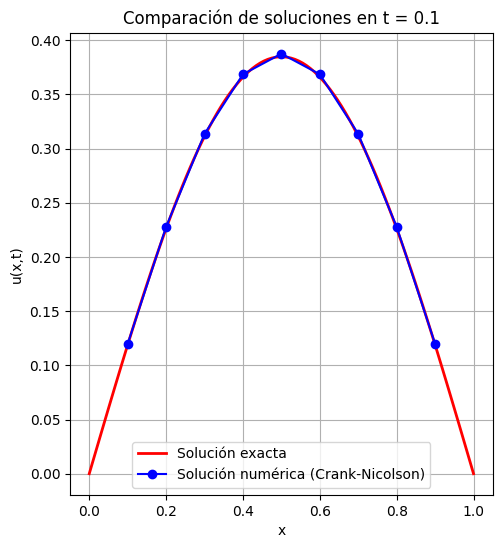

In [80]:
x_grafica = np.linspace(0, 1, 100)
u_exacta_grafica = [solucion_exacta(x, t_final) for x in x_grafica]

plt.figure(figsize=(12, 6))

# Gráfica de la solución completa
plt.subplot(1, 2, 1)
plt.plot(x_grafica, u_exacta_grafica, 'r-', label='Solución exacta', linewidth=2)
plt.plot(x_puntos, u_numerica_final, 'bo-', label='Solución numérica (Crank-Nicolson)', markersize=6)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f'Comparación de soluciones en t = {t_final}')
plt.legend()
plt.grid(True)

#Mapa de colores para Crank-Nicolson

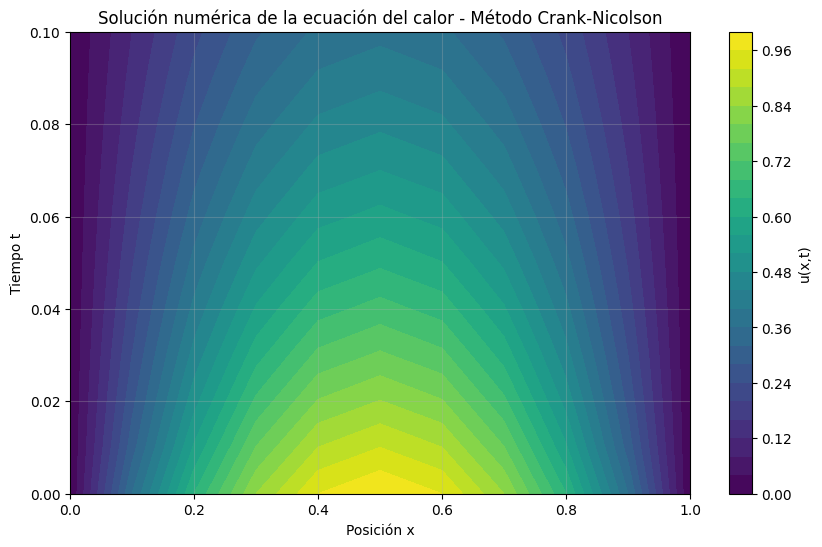

In [81]:
# Datos para el mapa de colores
x_completo = np.linspace(0, 1, 11)  # Incluye bordes (0 y 1)
t_completo = np.linspace(0, 0.1, num_pasos_temporales + 1)  # Tiempos de 0 a 0.1
X, Y = np.meshgrid(x_completo, t_completo)

# Construir matriz U_completa con bordes
U_completa = np.zeros((num_pasos_temporales + 1, 11))
for i in range(num_pasos_temporales + 1):
    U_completa[i, 0] = 0.0  # x=0
    U_completa[i, -1] = 0.0  # x=1
    if i < len(U):
        U_completa[i, 1:10] = U[i]  # Puntos interiores

# Crear el mapa de colores CORREGIDO
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, U_completa, levels=25, cmap=cm.viridis)
plt.colorbar(contour, label='u(x,t)')  # Corregido: 'label' en lugar de 'labels'
plt.title('Solución numérica de la ecuación del calor - Método Crank-Nicolson')
plt.xlabel('Posición x')
plt.ylabel('Tiempo t')
plt.xlim(0, 1)      # x de 0 a 1
plt.ylim(0, 0.1)    # t de 0 a 0.1 (sin espacios en blanco)

plt.grid(True, alpha=0.3)
plt.show()

#Visualización 3D de la solución completa

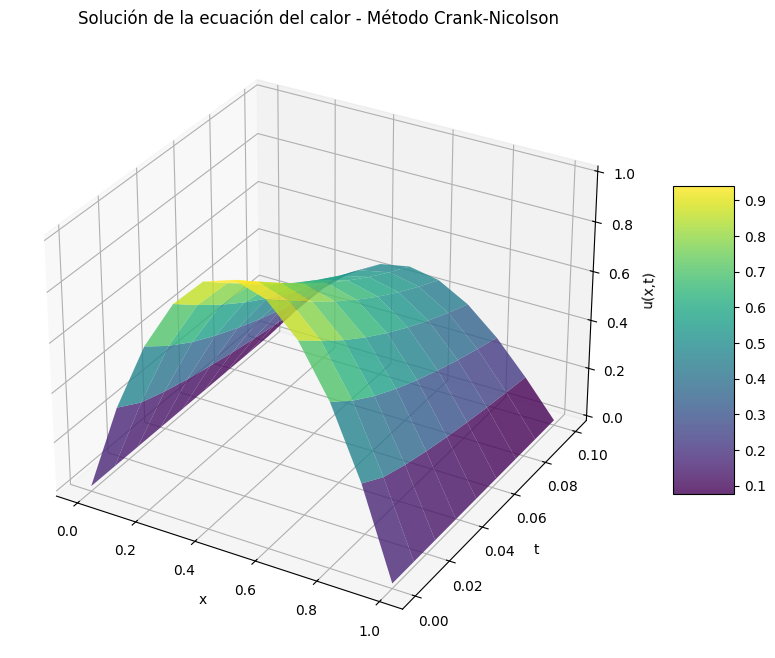

In [82]:
x_3d = np.linspace(0, 1, 11)  # Incluye bordes
y_3d = np.linspace(0, 0.1, j + 1)
X, Y = np.meshgrid(x_3d, y_3d)

# Construir matriz U completa con bordes
U_completo = np.zeros((j + 1, 11))
for i in range(j + 1):
    U_completo[i, 0] = 0.0  # x=0
    U_completo[i, -1] = 0.0  # x=1
    if i < len(U):
        U_completo[i, 1:10] = U[i]  # Puntos interiores

# Gráfica 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, U_completo, cmap=cm.viridis, alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Solución de la ecuación del calor - Método Crank-Nicolson')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

#Análisis de convergencia

In [83]:
print("\nAnálisis de convergencia:")
print(f"Parámetro r = {r:.2f}")
print("El método de Crank-Nicolson es incondicionalmente estable.")
print(f"El error máximo de {error_maximo:.6f} indica buena precisión del método.")
print(f"Pasos temporales: {num_pasos_temporales}")
print(f"Tiempo final: {t_final}")
print("La solución numérica converge a la solución exacta conforme t aumenta.")


Análisis de convergencia:
Parámetro r = 1.00
El método de Crank-Nicolson es incondicionalmente estable.
El error máximo de 0.002805 indica buena precisión del método.
Pasos temporales: 10
Tiempo final: 0.1
La solución numérica converge a la solución exacta conforme t aumenta.
